### Neural network training

This is the network used in [script2.ipynb](./script2.ipynb). It processes a 1-band (grayscale) image and generates a grayscale output image of the same width/height, to be used as a mask.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

print(tf.__version__)

rng = tf.random.Generator.from_seed(1234)

#Jupyter notebook commands
import IPython.display as disp
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.dpi'] = 200


2.6.0


### Preprocessing

- The image set used is located in `data/NN_training`, which has around 3000 slices of 128x128 images of the night sky (including features such as clouds, buildings, the horizon, light pollution, etc as well). Each image has a corresponding black & white mask that identifies the stars (*only*) in the image. The (image, mask) pair are identified by their common filename within their directories. <br> Note : The images were selected and masks were hand-drawn by me. Some may be inconsistent.

- Naturally, the neural network cannot process an image of arbitrary dimensions. I chose $128 \times 128$ as the fixed size since it seemed to best fit all the constraints of (i) being a small-ish size so that the number of trainable parameters does not need to be too large (ii) Be reasonably small compared to the dimensions of the actual full photograph, usually 2000-8000 pixels in width when taken with a good DSLR camera without reducing stize/resolution, and (iii) large enough to actually fit a star trail within it (short 1-2 min exposure, with a 50mm lens or more zoomed in), so that the ends can also be detected

- The dataset then must be **Augmented** and optimized for performance while training. I learnt most of these augmentation methods from the [Data Augmentation Guide page](https://www.tensorflow.org/tutorials/images/data_augmentation) on the Tensorflow website. The augmentation makes this limited dataset better at representing any of the vastly different star trail images that actually exist in real life, by :
    - *Rotating* images randomly, star trails can have any orientation (this is most important, since a majority of images in my dataset have stars moving in very similar directions, diagonally)
    - Adjusting the *Hue*, *Brighness* & *Contrast* since the sky/background and foreground feature colours can also be almost anything (also affects the shade of grey) !
    - Make the image grayscale, since there's not much info in the colours necessary to recognize stars & it's a good way to make the model more efficient.
    
- The `configure_for_performance` steps are as used in many of the tutorials on working with images & neural networks on the Tensorflow website.

More tensorflow references : [CNNs](https://www.tensorflow.org/tutorials/images/cnn), [Basics](https://www.tensorflow.org/tutorials/keras/classification)


In [2]:
list_imgs = tf.data.Dataset.list_files('data/NN_training/images/*/*', shuffle=False)
list_mask = tf.data.Dataset.list_files('data/NN_training/masks/*/*', shuffle=False)
num_images = tf.data.experimental.cardinality(list_imgs).numpy()
num_masks  = tf.data.experimental.cardinality(list_mask).numpy()
assert num_images == num_masks

# Everywhere operations are randomly performed (shuffling, rotation, etc)
# The same must be performed on an image & its corresponding mask
# Use the same seed in all the random functions, and seperate RNGs for images & masks
SHUFFLE_SEED = int(rng.uniform_full_int([1])[0].numpy() // 1000)  # 472453817354278 
print(SHUFFLE_SEED)

list_imgs = list_imgs.shuffle(num_images, seed=SHUFFLE_SEED)
list_mask  = list_mask.shuffle(num_images, seed=SHUFFLE_SEED)

# Verify that they are shuffled
for f in list_imgs.take(10):
  print(f.numpy())
for f in list_mask.take(10):
  print(f.numpy())

# Data augmentation - in the source files, star trails only have 3 orientations
# But the model should be able to evaluate any angle
rotator1 = tf.keras.layers.RandomRotation(0.25, fill_mode='wrap', seed=SHUFFLE_SEED)
rotator2 = tf.keras.layers.RandomRotation(0.25, fill_mode='wrap', seed=SHUFFLE_SEED)

def load_preprocess(imgpath, maskpath):
    img = tf.io.read_file(imgpath)
    img = tf.io.decode_image(img)
    img.set_shape([128, 128, 3])
    img = rotator1(img)
    # img = tf.image.stateless_random_brightness(img, 0.5, seed=[SHUFFLE_SEED]*2)
    img = tf.image.adjust_contrast(img, 2.0)
    img = tf.image.stateless_random_hue(img, 0.2, seed=[SHUFFLE_SEED]*2)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.cast(img, tf.float32) / 255.0
    # Set `img` to a 3-channel (RGB) 128x128 tensor normalised to [0.0 - 1.0]

    mask = tf.io.read_file(maskpath)
    mask = tf.io.decode_image(mask, channels=1)
    mask = tf.math.greater(mask, tf.constant(20, dtype=tf.uint8))
    mask = tf.where(mask, 1, 0)
    mask.set_shape([128, 128, 1])
    mask = rotator2(mask)
    # Set `mask` to a 1-channel binary (0 or 1) 128x128 tensor

    return (img, mask)


ds = tf.data.Dataset.zip((list_imgs, list_mask)).map(load_preprocess, tf.data.AUTOTUNE)

BATCH_SIZE = 10

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds = configure_for_performance(ds)

# tf.data.experimental.save(ds, 'data/tfdataset')

472453817354278
b'data/NN_training/images/02_018/12_10.JPG'
b'data/NN_training/images/4J7A0146/2_17.jpg'
b'data/NN_training/images/02_018/22_5.JPG'
b'data/NN_training/images/4J7A0146/0_7.jpg'
b'data/NN_training/images/02_018/19_5.JPG'
b'data/NN_training/images/02_018/12_8.JPG'
b'data/NN_training/images/4J7A0146/7_1.jpg'
b'data/NN_training/images/02_018/24_6.JPG'
b'data/NN_training/images/4J7A6522/17_17.jpg'
b'data/NN_training/images/4J7A6522/23_3.jpg'
b'data/NN_training/masks/02_018/12_10.jpg'
b'data/NN_training/masks/4J7A0146/2_17.jpg'
b'data/NN_training/masks/02_018/22_5.jpg'
b'data/NN_training/masks/4J7A0146/0_7.jpg'
b'data/NN_training/masks/02_018/19_5.jpg'
b'data/NN_training/masks/02_018/12_8.jpg'
b'data/NN_training/masks/4J7A0146/7_1.jpg'
b'data/NN_training/masks/02_018/24_6.jpg'
b'data/NN_training/masks/4J7A6522/17_17.jpg'
b'data/NN_training/masks/4J7A6522/23_3.jpg'


### Prepared Dataset Preview

(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)


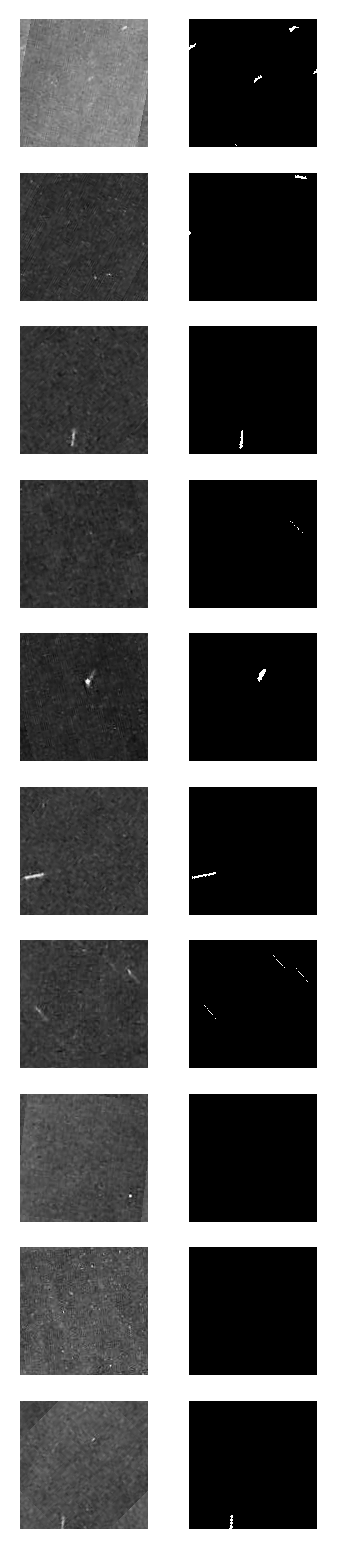

In [3]:
image_batch, mask_batch = next(iter(ds))

disp.display(disp.Markdown("### Prepared Dataset Preview"))
fig1 = plt.figure(figsize=(2,1*BATCH_SIZE))

# Preview part of the prepared dataset
for i in range(BATCH_SIZE):
    ax = plt.subplot(BATCH_SIZE, 2, 2*i+1)
    print(image_batch[i].shape)
    plt.imshow(image_batch[i].numpy(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    ax = plt.subplot(BATCH_SIZE, 2, 2*i+2)
    plt.imshow(mask_batch[i].numpy(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

plt.show()

### Architecture

This was one of the most confusing aspects to me as a beginner in this area, without knowing any of the terminology. It's also probably the most crucial aspect in creating a program that'll do the task well, and probably still has a lot of room for improvement in this project.

After reading up a bit, I drew from implementation examples of 3 different broad categories of networks which were similar to what I wanted in different ways :
- ***Image Segmentation*** networks, because these identify specific objects/features in an image and highlight/select their location in all the pixels (stars in this case).
- ***Autoencoders***, because their input is an image and output also an image of the same dimensions. Generally these are used to just compress or "encode" (as in the name) the image data more efficiently -> the output of an autoencoder looks relatively similar to the input image. Even here, the most of the background is dark sky which needs to be made black, and only the stars made white (similar colours, just monochromatic !). Exceptions are the buildings/horizon/etc other features, which should not be highlighted.
- ***Generative Adversarial Networks***, because they are used to create images based on others. (Although, many are used to try to artficially draw "realistic"-looking detailed pictures, and I only need a black & white mask of a given image...)

The kind of architecture layers used in most of these include -
- **Convolution** layers. Convolving a matrix/kernel with the image is what can be used to mathematically "select" desired features and many many image-processing tasks are done using Convolutional Neural Networks. The values in the kernel are trainable parameters, which will be adjusted here to get a kernel that helps identifying regions containing stars. <br> `Conv2D` is used for 2-dimensional images, and I used a 3x3 kernel size because it is comparable to the width of a star trail (often just 2-4 pixels wide, a thin line), so it's sufficient to select it.
- **Pooling** layers. These reduce the size of the image substantially, which is good for gradually reducting the size of the image as is passes through the layers, removing features or any detail that we don't care about & narrowing down the number of pixels to process. This also helps in efficiency because the number of parameters in the network is also reduced. <br> In my case, I used `MaxPool` because the stars are brighter white features on a dark background, and also very thin. Thus, reduction by taking the max preserves the stars. (in case of Min pooling, dark pixels of the sky would get selected rather than stars, making them disappear entirely in just a few rounds. Average pooling will also fade them out.)

These neural networks (especially AutoEncoders) perform the processing by reducing the width/height dimensions of the image, maybe also increasing the number of bands ("shortening and elongating" the tensor, as illustrated in many diagrams); and then after the midway point, using complementary layers for each so far to bring the reduced image back to its original shape by doing exctly the reverse of the operations. The reverse layers here are `Conv2DTranspose` and `UpSampling2D`. (A **U-Net** structure).

I used `mean_squared_error` as the training loss metric since the input/output are both images (numeric data, not categorical), and it works well enough to adjust the weights properly, even though the accuracy is always very high because most of the pixels are "blank".

In [4]:
# Build the CNN model
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(128, 128, 1)),
    tf.keras.layers.Conv2D(4, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2D(4, 3, strides=1, activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(8, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2D(8, 3, strides=1, activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(16, 3, strides=1, activation='relu'),
    
    tf.keras.layers.Conv2DTranspose(8, 3, strides=1, activation='relu'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(4, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2DTranspose(4, 3, strides=1, activation='relu'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(2, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=1, activation='relu'),
    # tf.keras.layers.Softmax(),
], name='NN_decoder')

model1.compile(
    loss='mean_squared_error',
    optimizer="adam", 
    metrics=[tf.keras.metrics.BinaryAccuracy(),],
)
model1.summary()

Model: "NN_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 4)       40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 4)       148       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 8)         296       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 16)        1

In [5]:
# Train
# This can take a while, and use up a lot of resources (CPU/GPU memory, battery etc)
# Atleast 8 epochs of training before there are no obvious artefacts/distortions/unwanted highlights in the output images

model1.fit(ds, epochs=10, verbose=1)

Epoch 1/10
305/305 [==============================] - 28s 87ms/step - loss: 0.0022 - binary_accuracy: 0.9976
Epoch 2/10
305/305 [==============================] - 26s 84ms/step - loss: 0.0020 - binary_accuracy: 0.9977
Epoch 3/10
305/305 [==============================] - 27s 88ms/step - loss: 0.0019 - binary_accuracy: 0.9977
Epoch 4/10
305/305 [==============================] - 29s 96ms/step - loss: 0.0019 - binary_accuracy: 0.9978
Epoch 5/10
305/305 [==============================] - 30s 97ms/step - loss: 0.0018 - binary_accuracy: 0.9978
Epoch 6/10
305/305 [==============================] - 28s 91ms/step - loss: 0.0018 - binary_accuracy: 0.9978
Epoch 7/10
305/305 [==============================] - 26s 86ms/step - loss: 0.0018 - binary_accuracy: 0.9979
Epoch 8/10
305/305 [==============================] - 27s 89ms/step - loss: 0.0017 - binary_accuracy: 0.9979
Epoch 9/10
305/305 [==============================] - 32s 103ms/step - loss: 0.0017 - binary_accuracy: 0.9979
Epoch 10/10
305/30

### Results from the training dataset

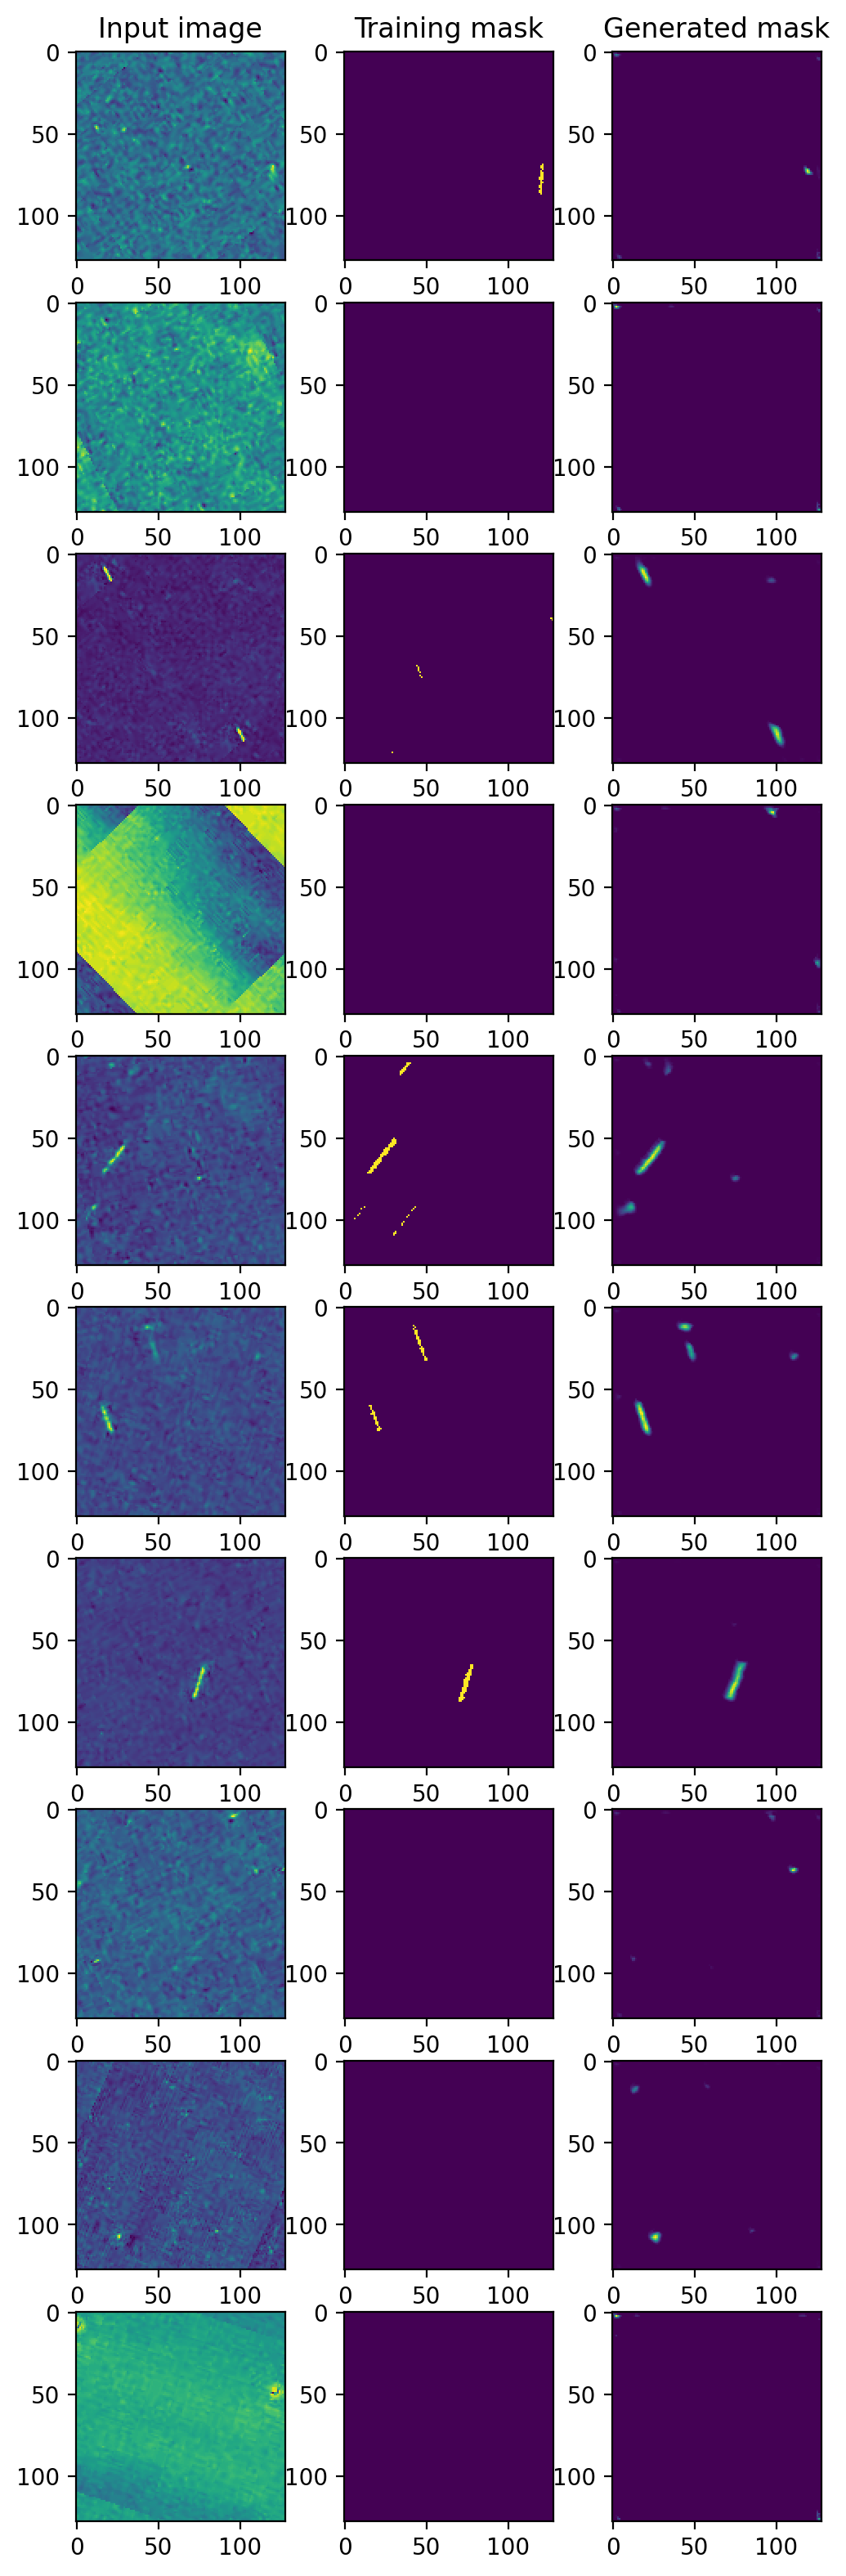

In [6]:
n = 1

# Check some of the model's results on training data
for imgbatch, maskbatch in ds.take(n):

    fig2, ax2 = plt.subplots(BATCH_SIZE, 3, figsize=(6, 2*BATCH_SIZE))
    disp.display(disp.Markdown("### Results from the training dataset"))
    predbatch = model1.predict(imgbatch)

    iter0 = True
    for imgtest, masktest, pred, ax in zip(imgbatch, maskbatch, predbatch, ax2) :
        ax[0].imshow(tf.keras.utils.array_to_img(imgtest))
        ax[1].imshow(tf.keras.utils.array_to_img(masktest))
        ax[2].imshow(tf.keras.utils.array_to_img(pred))
        if iter0 :
            ax[0].set_title("Input image")
            ax[1].set_title("Training mask")
            ax[2].set_title("Generated mask")
            iter0 = False
        # plt.close('all')
        

In [7]:
list_imgs2 = tf.data.Dataset.list_files('test/02_046/*', shuffle=True)

# Test
for f in list_imgs2.take(5):
  print(f.numpy())

def load_preprocess2(imgpath):
    img = tf.io.read_file(imgpath)
    img = tf.io.decode_image(img)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape([128, 128, 1])
    return img


dstest = list_imgs.map(load_preprocess2, tf.data.AUTOTUNE)

dstest = configure_for_performance(dstest)

b'test/02_046/15_10.JPG'
b'test/02_046/11_9.JPG'
b'test/02_046/11_0.JPG'
b'test/02_046/13_4.JPG'
b'test/02_046/25_6.JPG'


### Results from test dataset

### Results from test dataset

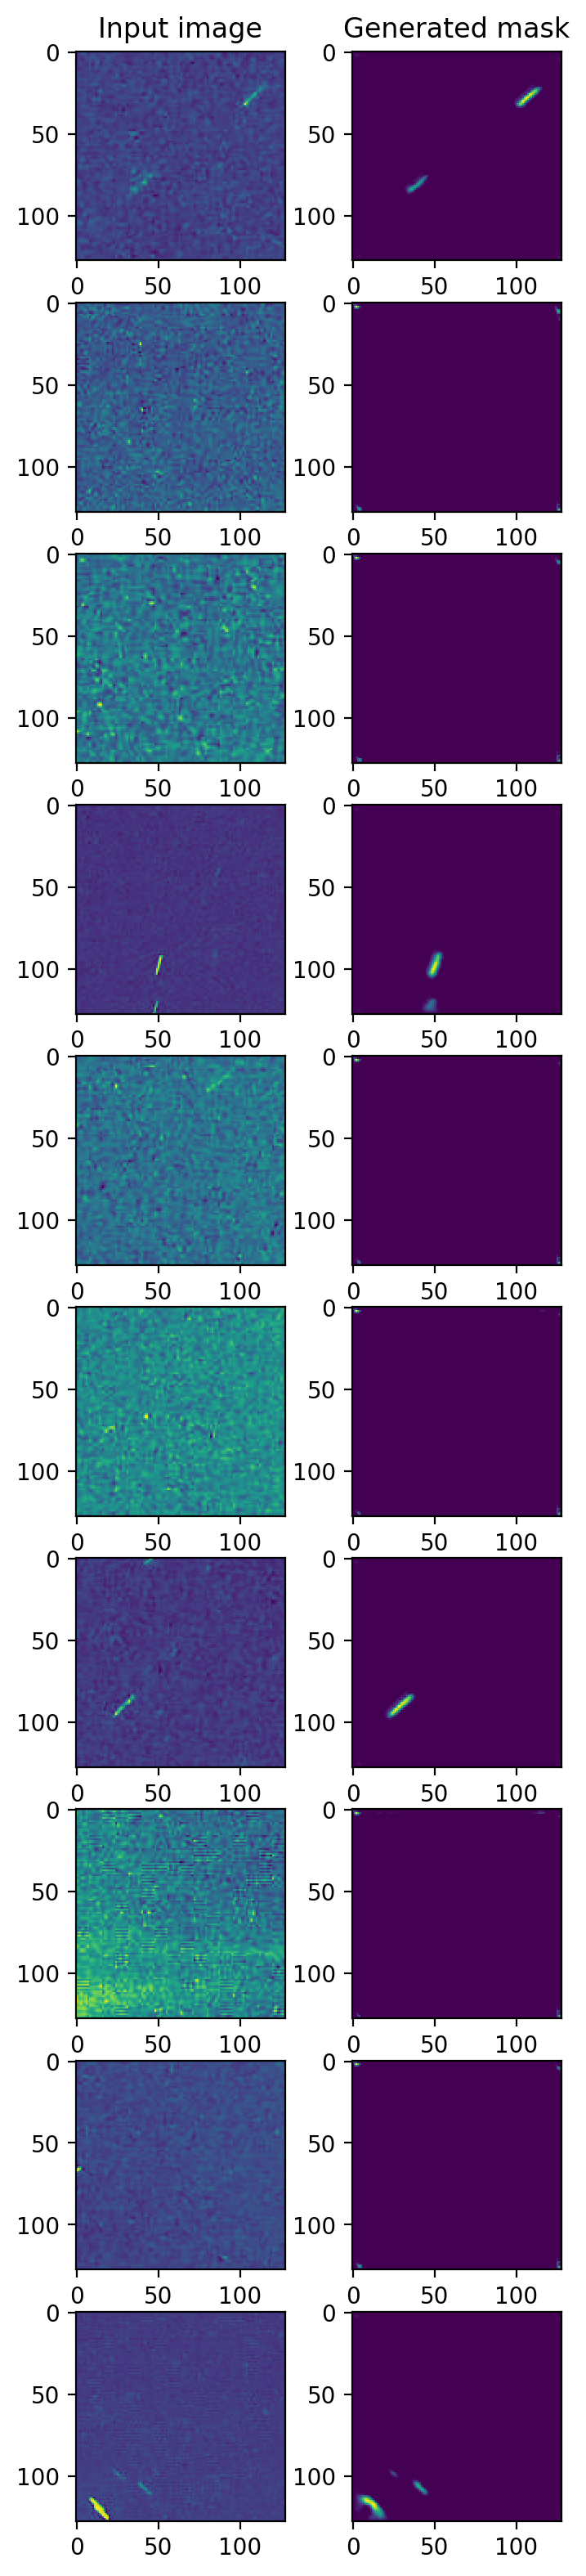

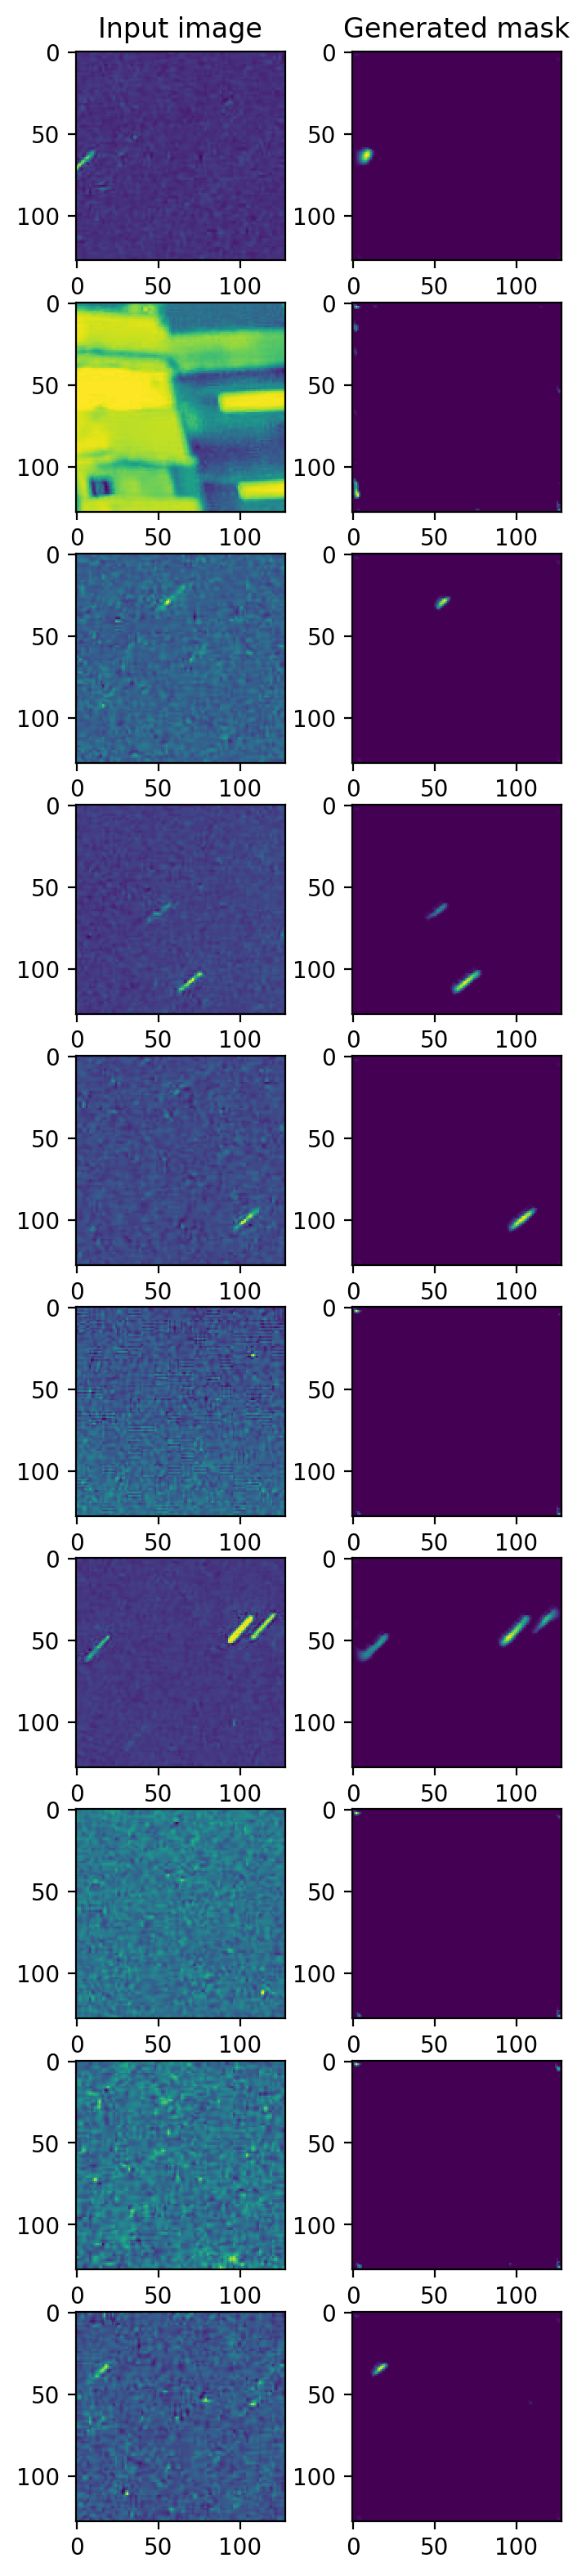

In [10]:
n = 2

for imgbatch in dstest.take(n):

    fig3, ax3 = plt.subplots(BATCH_SIZE, 2, figsize=(4, 2*BATCH_SIZE))
    disp.display(disp.Markdown("### Results from test dataset"))
    predbatch = model1(imgbatch)
    iter0 = True

    for imgtest, pred, ax in zip(imgbatch, predbatch, ax3) :
        ax[0].imshow(tf.keras.utils.array_to_img(imgtest))
        ax[1].imshow(tf.keras.utils.array_to_img(pred))
        if iter0 :
            ax[0].set_title("Input image")
            ax[1].set_title("Generated mask")
            iter0 = False


In [9]:
## Save the trained weights & model to disk
model1.save('data/CNNmodel1')

INFO:tensorflow:Assets written to: data/CNNmodel1/assets
